<a href="https://colab.research.google.com/github/nicolassalomon96/procesamiento_imagenes_UNS/blob/main/TP4/Histograma_de_luminancia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP4 - Histograma de Luminancias

* Generar una función que como parámetro de entrada tome la luminacia de una imagen y un numero entero de contadores y como salida obtengamos el histograma respectivo. Mostrar el histograma respectivo para 5 valores de contadores diferentes.

* Buscar dos imágenes con problemas de iluminación (una oscura y otra muy brillante, como las mostradas en las filminas de la clase Pag. 7). Verificar la premisa de que al multiplicar la luminancia por un valor alfa, el problema de iluminación no se corrige. Mostrar la imagen original, la resultante y sus respectivos histogramas, para un valor alfa dado.

* Implementar las funciones: Lineal a trozos para un valor Y_min y Y_max como parámetros de la función, raíz cuadrada y potencia cuadrática. Para estas usar las imágenes anteriores y mostrar cómo cambio la imagen y el histograma después de aplicar el filtro a la imagen.

## 1. Librerias necesarias

In [28]:
import os
import numpy as np
import imageio as io
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

## 2. Funciones necesarias

In [42]:
#Función para descargar imagen
def get_image(path):
  image = io.imread(path)
  image = image/255
  return image

#Función para mostrar una imagen RGB
def print_image(image,title,figsize=(15,15)):
  fig, ax = plt.subplots(figsize=figsize)
  plt.imshow(image)
  plt.title(title)
  plt.show()

#Funcion para crear un botón de guardado
def save_button(image,full_path):
  '''
  input: image=arreglo numpy obtenido luego de leer una imagen
         full_path=ruta completa de guardado (incluido nombre y extensión)
  '''
  #Función para guardar una imagen
  def save_image(image,full_path):
    image = np.uint8(image)
    io.imsave(full_path,image)
 
  my_button = widgets.Button(description='SAVE IMAGE')
  out = widgets.Output()

  def on_button_clicked(b):
     with out:
      #Que sucede al presionar el boton
      save_image(image,full_path)      
    
  my_button.on_click(on_button_clicked)
  display(my_button,out)

#Función para convertir una imagen del espacio RGB al YIQ
def rgb2yiq(RGB):
    '''
    input: matriz de la imagen en formato RGB normalizada
    output: matriz de la imagen en formato YIQ
    '''
    rgb2yiq_matrix = np.array([[0.299,0.587,0.114],[0.595716,-0.274453,-0.321263],[0.211456,-0.522591,0.311135]])
    #print("Matriz de conversion RGB a YIQ:")
    #print(rgb2yiq_matrix)

    #Se normalizan los valores de RGB entre 0.0 y 1.0 (ya estan normalizados al momento de leer la imagen)
    #RGB = RGB/255 

    Y = rgb2yiq_matrix[0][0] * RGB[:,:,0] + rgb2yiq_matrix[0][1] * RGB[:,:,1] + rgb2yiq_matrix[0][2] * RGB[:,:,2]
    I = rgb2yiq_matrix[1][0] * RGB[:,:,0] + rgb2yiq_matrix[1][1] * RGB[:,:,1] + rgb2yiq_matrix[1][2] * RGB[:,:,2]
    Q = rgb2yiq_matrix[2][0] * RGB[:,:,0] + rgb2yiq_matrix[2][1] * RGB[:,:,1] + rgb2yiq_matrix[2][2] * RGB[:,:,2]

    Y = np.clip(Y, 0, 1)
    I = np.clip(I, -0.5957, 0.5957)
    Q = np.clip(Q, -0.5226, 0.5226)
    
    YIQ = np.dstack((Y,I,Q))
    
    return YIQ

#Función para convertir una imagen del espacio YIQ al RGB 
def yiq2rgb(YIQ):
    '''
    input: matriz de la imagen en formato YIQ 
    output: matriz de la imagen en formato RGB (en bytes)
    '''
    yiq2rgb_matrix = np.array([[1,0.9663,0.6210],[1,-0.2721,-0.6474],[1,-1.1070,1.7046]])
    #print("Matriz de conversion YIQ a RGB:")
    #print(yiq2rgb_matrix)

    R = yiq2rgb_matrix[0][0] * YIQ[:,:,0] + yiq2rgb_matrix[0][1] * YIQ[:,:,1] + yiq2rgb_matrix[0][2] * YIQ[:,:,2]
    G = yiq2rgb_matrix[1][0] * YIQ[:,:,0] + yiq2rgb_matrix[1][1] * YIQ[:,:,1] + yiq2rgb_matrix[1][2] * YIQ[:,:,2]
    B = yiq2rgb_matrix[2][0] * YIQ[:,:,0] + yiq2rgb_matrix[2][1] * YIQ[:,:,1] + yiq2rgb_matrix[2][2] * YIQ[:,:,2]

    #Se controla que no haya pixeles con valores menores a 0 y mayores a 1 (Dadas las multiplicaciones y sumas realizadas,
    #puede ocurrir que un valor exceda un poco el límite de 255 o sea ligeramente menor a 0 ocasionando errores en la visualización)
    R = np.clip(R, 0, 1)
    G = np.clip(G, 0, 1)
    B = np.clip(B, 0, 1)

    #Se convierten los valores a byte (valores enteros de 0 a 255)
    R = (R*255).astype(int)
    G = (G*255).astype(int)
    B = (B*255).astype(int)    
    
    RGB = np.dstack((R,G,B))
    
    return RGB  

#Función para generar el histograma de luminancia de la imagen
def generate_histo(Y, min, max, steps):
  
  bins = np.round(np.linspace(min, max, steps+1),6) #Genera las divisiones en base al número de contadores
  #Aclaración: se redondea a 6 decimales como máximo para evitar errores debido a la representación de los números con punto flotante
  counts, bins_edges = np.histogram(Y, bins)

  #Cálculo de la frecuencia relativa para generar el histograma de frecuencia
  total_counts = sum(counts)
  counts_relative_freq = np.round(((counts*100)/total_counts),2)
  
  plt.figure(figsize=(15,6))

  plt.hist(bins[:-1], bins, weights=counts_relative_freq, ec='black')
  plt.title("Histograma de Luminancia")
  plt.xlabel("Luminancias")
  plt.ylabel("Frecuencia %")
  plt.xticks(np.arange(0,1.1,bins[2]-bins[0]))
  
  plt.show()  

  return counts, bins_edges

## 3. Selección de la imagen

In [56]:
#@title Seleccione la imagen a analizar: { run: "auto" }
dog_url = 'https://pbs.twimg.com/media/BwURyszIYAEtRva.jpg'
route_url = 'https://cdn1.eldia.com/122017/1514109535760.jpg'
lake_url = 'https://s1.1zoom.me/prev/596/USA_Mountains_Lake_Forests_Sky_Lake_Dillon_Clouds_595131_600x400.jpg'
low_Y_1 = 'https://cdn.shopify.com/s/files/1/0268/6861/files/cat-4373086_960_720_grande.jpg?v=1576688425'
low_Y_2 = 'https://cdn.photography-secret.com/7581913/How_to_Improve_Low-Light_Performance_by_Increasing_Your_ISO_20.jpg.webp'


Imagen = 'Baja_Luminancia_2' #@param ["Perro","Ruta","Lago","Baja_Luminancia_1","Baja_Luminancia_2"]

if Imagen =='Perro':
  image = get_image(dog_url)
if Imagen =='Ruta':
  image = get_image(route_url)
if Imagen =='Lago':
  image = get_image(lake_url)
if Imagen =='Baja_Luminancia_1':
  image = get_image(low_Y_1)
if Imagen =='Baja_Luminancia_2':
  image = get_image(low_Y_2)  

print_image(image,'Imagen',figsize=(10,10))

HTTPError: ignored

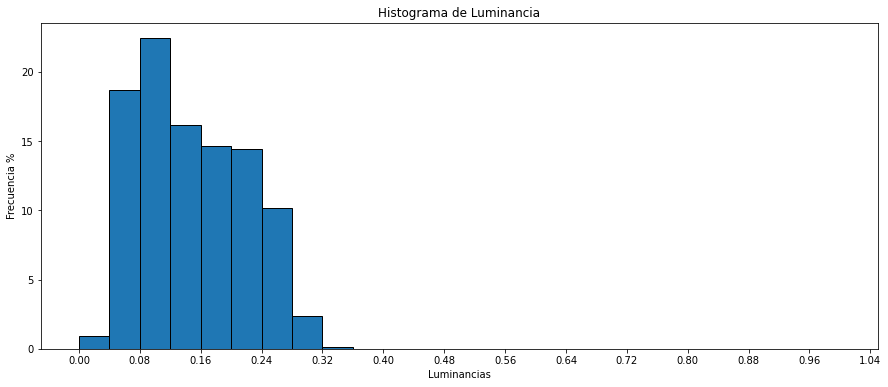

In [52]:
#@title Seleccione la cantidad de contadores: { run: "auto" }

Contadores = 25 #@param {type:"slider", min:1, max:50, step:1}
image_y = rgb2yiq(image)[:,:,0] #Extracción del canal Y (luminancia) de la imagen

counts, bins = generate_histo(image_y,0,1,Contadores)